In [0]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import OrderedDict
from operator import itemgetter
from wordcloud import WordCloud

In [0]:
all_df = pd.read_csv('/content/drive/My Drive/procAllCharLines.csv')
sel_df = pd.read_csv('/content/drive/My Drive/procSelectCharLines.csv')

In [16]:
all_df.head()

,Season,Episode,Character,Line,Processed Line
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away
1,10,1,Kyle,Going away? For how long?,going away for how long
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...
3,10,1,Mrs. Garrison,Chef?? What kind of questions do you think adv...,chef what kind of questions do you think adven...
4,10,1,Chef,What's the meaning of life? Why are we here?,whats the meaning of life why are we here


In [17]:
sel_df.head()

,Season,Episode,Character,Line,Processed Line
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away
1,10,1,Kyle,Going away? For how long?,going away for how long
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...
3,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,im gonna miss him im gonna miss chef and i an...
4,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...",dude how are we gonna go on chef was our fuh f...


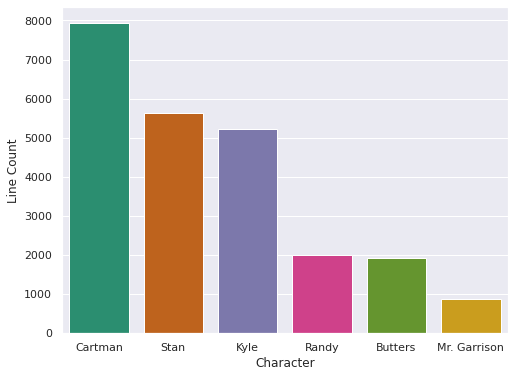

In [18]:
sns.set(rc={'figure.figsize':(8,6)})
ax = sns.countplot(x='Character', data=sel_df, palette='Dark2', 
                   order=sel_df['Character'].value_counts().index)
ax.set(ylabel='Line Count')
plt.show()

Lets add the word count for each line as a new column so we may compare the distribution of line lengths per character...

In [0]:
sel_df['Word Count'] = sel_df['Processed Line'].map(
    lambda x: str(x).count(' ')+1
    )

In [20]:
sel_df.head()

,Season,Episode,Character,Line,Processed Line,Word Count
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away,8
1,10,1,Kyle,Going away? For how long?,going away for how long,5
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...,15
3,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,im gonna miss him im gonna miss chef and i an...,19
4,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...",dude how are we gonna go on chef was our fuh f...,12


Now to display the distribution...

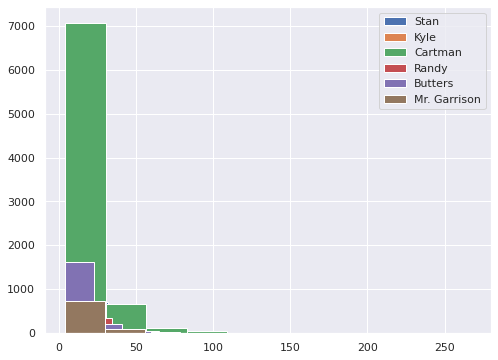

In [21]:
for char in sel_df['Character'].unique():
  plt.hist(list(sel_df.loc[sel_df['Character']==char, 'Word Count']), label=char)
plt.legend(loc='upper right')
plt.show()

We can see almost all the line lengths are less than 50 words long, let's take a closer look by limiting the x-axis to 50, and having bin sizes of 1.

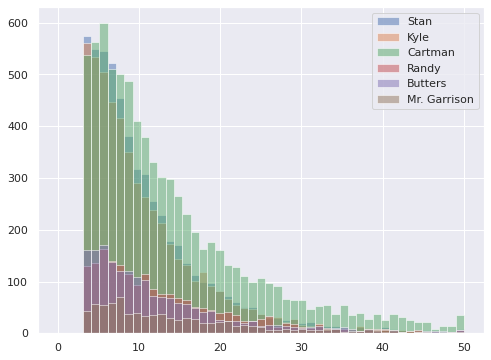

In [22]:
bins = np.linspace(0,50,50)

for char in sel_df['Character'].unique():
  plt.hist(list(sel_df.loc[sel_df['Character']==char, 'Word Count']), 
           bins, alpha=0.5, label=char)
plt.legend(loc='upper right')
plt.show()

For the most part, the line lengths for each character have similar distributions...

Let's take a look at the top words for each character...

In [23]:
# Download stop words from NLTK

nltk.download('stopwords')

stopwords = nltk.corpus.stopwords.words()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# This is inefficient - find better way!

def get_top_words(character, df, storage = {}):
  for line in df.loc[df['Character']==character, 'Processed Line']:
    tokens = line.split(' ')
    for word in tokens:
      if word in nltk.corpus.stopwords.words() or word == '':
        continue
      elif word in storage:
        storage[word] += 1
      else:
        storage[word] = 1

  top_words = OrderedDict(sorted(storage.items(), key=itemgetter(1)))
  
  return [(k,v) for k,v in top_words.items()][::-1]

In [0]:
def word_cloud(character, df, word_list = []):
  for line in df.loc[df['Character']==character, 'Processed Line']:
    tokens = line.split(' ')
    word_list.extend([word for word in tokens])
  
  print('-----------------\n{}\n-----------------'.format(character))

  wordcloud = WordCloud(width=500, height=250,
                        stopwords=stopwords).generate(' '.join(word_list))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [0]:
# top_C = get_top_words('Mr. Garrison', sel_df)

-----------------
Stan
-----------------


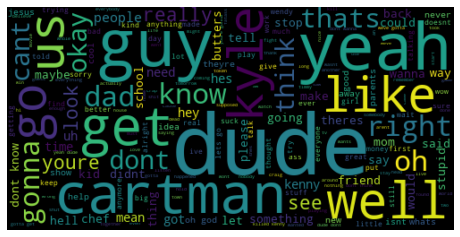

-----------------
Kyle
-----------------


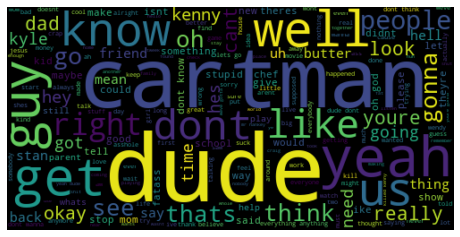

-----------------
Cartman
-----------------


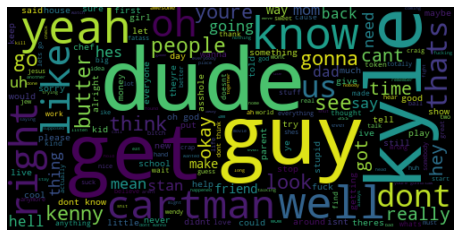

-----------------
Randy
-----------------


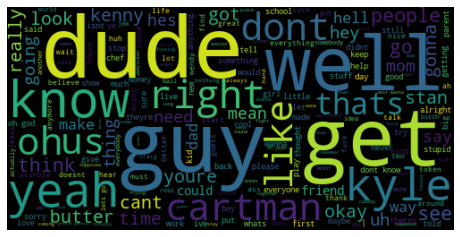

-----------------
Butters
-----------------


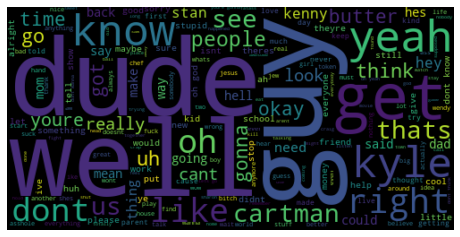

-----------------
Mr. Garrison
-----------------


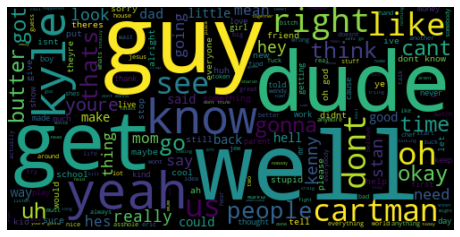

In [25]:
for char in sel_df['Character'].unique():
  word_cloud(char, sel_df)

Whilst word clouds don't tell us too much, they are cool to see. We can see our characters love the word 'dude' :P.

Let us now take a look at the sentiment for each character, I'm inclinded to believe Cartman or Randy will be the most negative...

We will use the [VADER](https://github.com/cjhutto/vaderSentiment) module from NLTK (Really powerful sentiment model, capable of capturing nuanced semantics).

In [26]:
# Download vader lexicon
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [0]:
senti_model = SentimentIntensityAnalyzer()

In [0]:
def get_sentiment(line):
  ss = senti_model.polarity_scores(line)
  if ss['compound'] >= 0.05:
    return 'positive'
  elif ss['compound'] <= -0.05:
    return 'negative'
  else:
    return 'neutral'

In [0]:
sel_df['Sentiment'] = sel_df['Line'].map(lambda x: get_sentiment(x))

In [33]:
sel_df.head()

,Season,Episode,Character,Line,Processed Line,Word Count,Sentiment
0,10,1,Stan,"You guys, you guys! Chef is going away.",you guys you guys chef is going away,8,neutral
1,10,1,Kyle,Going away? For how long?,going away for how long,5,neutral
2,10,1,Stan,"Chef said he's been bored, so he joining a gro...",chef said hes been bored so he joining a group...,15,positive
3,10,1,Cartman,I'm gonna miss him. I'm gonna miss Chef and I...,im gonna miss him im gonna miss chef and i an...,19,negative
4,10,1,Stan,"Dude, how are we gonna go on? Chef was our fuh...",dude how are we gonna go on chef was our fuh f...,12,neutral


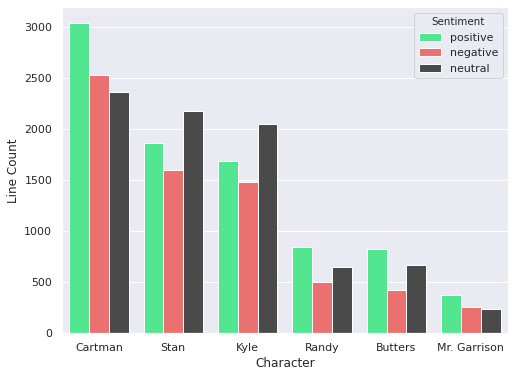

In [51]:
g_r_gr = ['#38ff8b', '#ff5c5c', '#4a4a4a']

ax = sns.countplot(x='Character', hue='Sentiment', 
                   hue_order=['positive', 'negative', 'neutral'],
                   order=sel_df['Character'].value_counts().index,
                   data=sel_df, palette=g_r_gr)
ax.set(ylabel='Line Count')
plt.show()

Nice, looks like Cartman isn't that negative afterall! Let's see how the sentiment varies with each season.

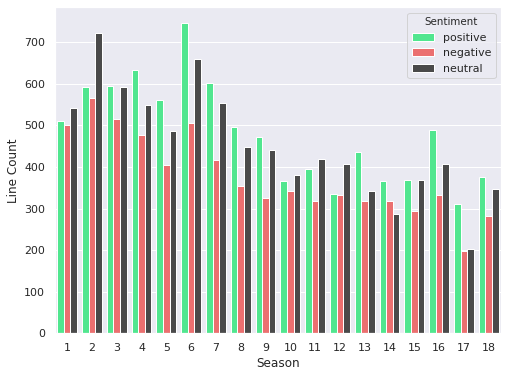

In [52]:
ax = sns.countplot(x='Season', hue='Sentiment', data=sel_df,
                   hue_order=['positive', 'negative', 'neutral'],
                   palette=g_r_gr)
ax.set(ylabel='Line Count')
plt.show()